In [1]:
!pwd

/Users/vascomeerman/Coding/Harvard/CS215/Project/Style-Transfer-App


In [1]:
import torch
import time
from PIL import Image
import onnxruntime as ort
import numpy as np
# from onnx_tf.backend import prepare
import onnx
# from helpers.common import normalization

from argparse import Namespace
# 
# from models.psp_project.stylegan2.model import Generator
# from models.psp_project.psp.models import pSp
from utils.common import tensor2im, log_input_image
from models.psp import pSp

# from models.psp.stylegan2.model import Generator


ModuleNotFoundError: No module named 'utils.common'

In [2]:
WEIGTHS_PATH = 'v3_psp/pretrained_models'
ONNX_OUT_PATH = ''


In [3]:
# Original full model paths
CHECKPOINT_OG_ENC_DEFAULT = f'{WEIGTHS_PATH}/psp_ffhq_encode.pt'
CHECKPOINT_OG_ENC_TOON = f'{WEIGTHS_PATH}/original/psp_ffhq_toonify.pt'


In [4]:
# Mobile smaller versions
CHECKPOINT_M_ENC_CARTOON = f'{WEIGTHS_PATH}/mobile/cartoon_psp_mobile_256p.pt'
# CHECKPOINT_M_TOON = f'{WEIGTHS_PATH}/mobile/psp_ffhq_toonify.pt'

In [5]:
import os
os.path.isdir(ONNX_OUT_PATH) 
print(os.path.basename(CHECKPOINT_OG_ENC_DEFAULT))



psp_ffhq_encode.pt


In [8]:

def enc_torch_to_onnx(cpth_path, output_path):

    # Load the model checkpoint weight into torch on cpu
    ckpt = torch.load(cpth_path,
                        map_location='cpu')

    # Load model options
    opts = Namespace(**ckpt['opts'])
    
    # Change default checkpoint weights path to new one
    opts.checkpoint_path = cpth_path
    
    if 'learn_in_w' not in opts:
        opts.learn_in_w = False
    if 'output_size' not in opts:
        opts.output_size = 1024
    
    # Change device to be CPU, since no we don't have gpu cuda support for onnx
    opts.device = "cpu"

    # Load the full model with weights and options we just set
    net = pSp(opts)
    
    # Set to evaluation mode, so only inference aka not training and gradients
    net.eval()

    # Example input image with batch size 1, 3 colors and size 256 by 256
    img_tensor = torch.randn(1, 3, 256, 256)

    # Inputs needed for onnx to run 1 inference session so it can determine 
    # the graph it needs to convert
    inputs = (img_tensor.float(),
              {"randomize_noise": False,
                "return_latents": True}
              )


    # To specify axes of tensors as dynamic (i.e. known only at run-time),
    # set dynamic_axes to a dict for dynamic input and output values  
    dynamic_axes = {'input': {0: 'batch'}, 'output': {0: 'batch'}}
    
    # Path of new .onnx file to write
    output_file_name = os.path.basename(CHECKPOINT_OG_ENC_DEFAULT).replace(".pt", ".onnx")
    output_full_path = f"{output_path}/{output_file_name}"
    
    # See all options, scroll down to "Functions", see:
    # https://pytorch.org/docs/stable/onnx.html
    # https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html
    torch.onnx.export(
        model=net,
        args=inputs, # If other args then only input, need to be tuple with dict
        f=output_full_path, # Where binary onnx will be written to
        verbose=False,
        # See: https://github.com/pytorch/fairseq/issues/3395
        operator_export_type=torch.onnx.OperatorExportTypes.ONNX_ATEN_FALLBACK,
        # Constant-folding will replace some of the ops that have
        # all constant inputs with pre-computed constant nodes.
        # do_constant_folding=True,
        # input_names=['input'],
        # output_names=['output'],
        opset_version=12,
        export_params=True,               

    )
    
    print("donee")
    return output_full_path

In [9]:
onnx_path = enc_torch_to_onnx(CHECKPOINT_OG_ENC_DEFAULT, ONNX_OUT_PATH)
print(f"Model succesfully written to -> {onnx_path}")

Loading pSp from checkpoint: v3_psp/pretrained_models/psp_ffhq_encode.pt


RuntimeError: Unsupported: ONNX export of convolution for kernel of unknown shape.

## Checking and testing inference

In [10]:

# from models.psp_project.helpers.common import detect_and_align_face
# from onnx_tf.backend import prepare


In [11]:
# https://stackoverflow.com/questions/67480507/tensorflow-equivalent-of-pytorchs-transforms-normalize
def normalize_image_pytorch_style(image, mean, std):
    for channel in range(3):
        image[:,:,channel] = (image[:,:,channel] - mean[channel]) / std[channel]
    return image



def load_preprocess_image_from_path(img_path):
    print("Image", img_path)
    
    # Open the image into the right dimensions
    img = Image.open(img_path)
    img = img.convert("RGB")
    img = img.resize((256, 256))

    # Normalized img dimensions to between -1 and 1
    # similar to how the original model did this in pytorch
    img_resized = normalize_image_pytorch_style(
                        np.array(img) / 255.0, 
                        mean=[0.5, 0.5, 0.5], 
                        std=[0.5, 0.5, 0.5])

    
    # Move color axis to start like model is used to
    img_resized = np.moveaxis(img_resized, 2, 0)

    # Add in the first batch dim
    input_batch_img = np.expand_dims(img_resized, axis=0)
    
    return input_batch_img.astype(np.float32)

In [15]:
tic = time.time()

# Convert model to tensorflow
model_psp = onnx.load(onnx_path)
# tf_rep_psp = prepare(model_psp)

toc = time.time()
print('Loading and converting PSP onnx to tf took {:.4f} seconds.'.format(toc - tic))

Loading and converting PSP onnx to tf took 0.7213 seconds.


ONNX Input name -> input and output -> output
Image data/portraits/dongyun.jpg


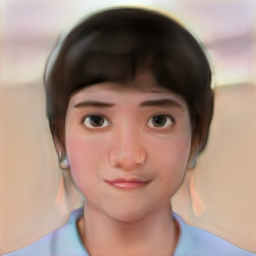

In [16]:
test_img = "data/portraits/dongyun.jpg"

ort_session = ort.InferenceSession(onnx_path)
input_name = ort_session.get_inputs()[0].name
ouput_name = ort_session.get_outputs()[0].name
print(f"ONNX Input name -> {input_name} and output -> {ouput_name}")

img = load_preprocess_image_from_path(test_img)



output = ort_session.run([ouput_name],
                        {input_name: img})[0]
output

# 
# print(output)

output = (output.squeeze().transpose((1, 2, 0)) + 1) / 2
output[output < 0] = 0
output[output > 1] = 1
output = normalization(output) * 255
output = Image.fromarray(output.astype('uint8'))
output

# output.save(os.path.join(args.save, "{}_{}_{}.png".format(
#     args.network,
#     args.platform,
#     image.split("/")[-1].split(".")[0]))
# )

In [27]:
out_img, out_lat = output

print(output)


ValueError: not enough values to unpack (expected 2, got 1)